In [1]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import random
from dataset import *
from model import *
import gc


In [35]:
class Args:
    def __init__(self):
        self.gpu = 1
        self.run_label = 0
        self.feat_size = 128
        self.batch_size = 8
        self.learning_rate = 1e-4
        self.n_sample = 256
        self.n_future = 10
        self.n_past = 2
        self.predictor_model = 'big'
        
args = Args()
device = torch.device('cuda:%d' % args.gpu)
args.device = device

In [3]:
while True:
    args.log_dir = '/data/hdim-forecast/log3/pred/model=%s-seq=%d/%d-ns=%d-feat_size=%d-bs=%d-lr=%.5f-run=%d' % \
        (args.predictor_model, args.n_past, args.n_future, args.n_sample, args.feat_size, 
         args.batch_size, args.learning_rate, args.run_label)
    if not os.path.isdir(args.log_dir):
        os.makedirs(args.log_dir)
        break
    args.run_label += 1
print("Run number = %d" % args.run_label)
writer = SummaryWriter(args.log_dir)
log_writer = open(os.path.join(args.log_dir, 'results.txt'), 'w')

start_time = time.time()
global_iteration = 0
random.seed(args.run_label)  # Set a different random seed for different run labels
torch.manual_seed(args.run_label)
    
def log_scalar(name, value, epoch):
    writer.add_scalar(name, value, epoch)
    log_writer.write('%f ' % value)
    
def message(epoch):
    print("Finished epoch %d, time elapsed %.1f" % (epoch, time.time() - start_time))

Run number = 4


In [4]:
feat_model = FeatureNetC(args.feat_size)
feat_model.load_state_dict(torch.load('pretrained/representation-c-%d.pt' % args.feat_size), strict=False)
feat_model = feat_model.to(device)
feat_model.eval()

FeatureNetC(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2))
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=14, bias=True)
)

In [25]:
# train_dataset = MovingMNIST(train=True, n_past=args.n_past, n_future=args.n_future, deterministic=False, last_only=True)
# train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=4)

multi_dataset = MovingMNISTMulti(train=True, n_past=args.n_past, n_future=args.n_future, n_sample=args.n_sample, deterministic=False, last_only=True)
multi_loader = DataLoader(multi_dataset, batch_size=args.batch_size, shuffle=True, num_workers=args.batch_size)

/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:211: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


In [20]:
predictor = predictors[args.predictor_model](args.feat_size).to(device)
# predictor = FeatureNetC(args.feat_size).to(device)
exp_optim = optim.Adam(predictor.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.StepLR(exp_optim, 20, 0.9)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


AttributeError: 'Args' object has no attribute 'log_dir'

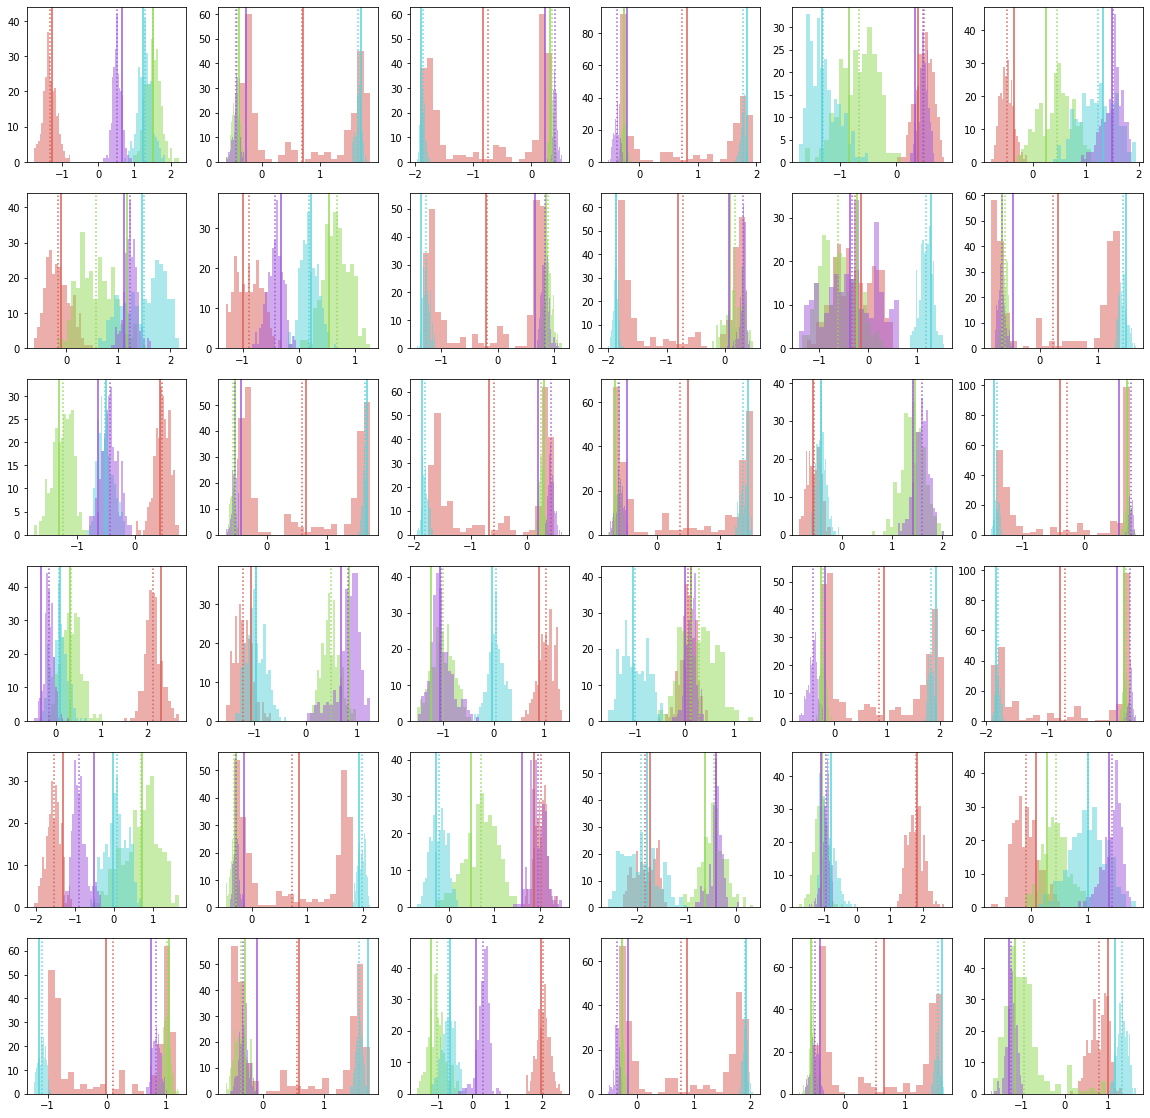

In [41]:
# Learn the conditional expectation
for epoch in range(2000):
    
    multi_dataset.set_nsample(4)
    for idx, data in enumerate(multi_loader):
        exp_optim.zero_grad()

        bx, by, bl = data
        bx = bx.to(device)

        actual_feat = feat_model(bx[:, :, -1].view(-1, 1, 64, 64)).view(args.batch_size, 4, args.feat_size).detach()
        actual_exp = actual_feat.mean(dim=1)
        pred_exp = predictor(bx[:, 0, 0:2])
        
        loss_l2 = (actual_exp - pred_exp).pow(2).mean()
        loss_l2.backward()

        writer.add_scalar('loss_l2', loss_l2, global_iteration)
        exp_optim.step()
        global_iteration += 1
            
    errors = []
    baseline_error = []
    num_elem = 0
    multi_dataset.set_nsample(args.n_sample)
    plt.figure(figsize=(20, 20))
    palette = sns.color_palette('hls', 4)
    with torch.no_grad():
        for idx, data in enumerate(multi_loader):
            bx, by, bl = data
            bx = bx.to(device)
            
            actual_feat = feat_model(bx[:, :, -1].view(-1, 1, 64, 64)).view(args.batch_size, args.n_sample, args.feat_size)
            actual_exp = actual_feat.mean(dim=1)
            pred_exp = predictor(bx[:, 0, 0:2])
            errors.append(actual_exp - pred_exp)
            
            baseline_error.append(actual_feat[:, :args.n_sample//2, :].mean(dim=1) - actual_feat[:, args.n_sample//2:, :].mean(dim=1))
            num_elem += args.batch_size
            if num_elem > 1000:
                break
            if idx < 4:
                for i in range(36):
                    plt.subplot(6, 6, i+1)
                    plt.hist(actual_feat[0, :, i].cpu().numpy(), bins=20, color=palette[idx], alpha=0.5)
                    plt.axvline(pred_exp[0, i], color=palette[idx])
                    plt.axvline(actual_exp[0, i], color=palette[idx], linestyle=':')
            elif idx == 4:
                os.makedirs(os.path.join(args.log_dir, 'plot'), exist_ok=True)
                plt.savefig(os.path.join(args.log_dir, 'plot', 'hist-%d.png' % (epoch // 10)))
                plt.close()
            
        errors = torch.cat(errors)
        baseline_error = torch.cat(baseline_error)
    writer.add_scalar('loss_exp_l1', errors.abs().mean(), global_iteration)
    writer.add_scalar('loss_exp_l1_base', baseline_error.abs().mean(), global_iteration)
    scheduler.step()
    message(epoch)

    if (epoch+1) % 10 == 0:
        torch.save(predictor.state_dict(), 'pretrained/predictor_%d-%d-%s.pt' % (args.feat_size, args.n_future, args.predictor_model))

In [37]:
print(actual_feat.shape)

torch.Size([8, 256, 128])


torch.Size([8, 256, 3, 1, 64, 64])
torch.Size([8, 256, 128])
torch.Size([8, 128])
torch.Size([8, 128])
torch.Size([8, 128])
torch.Size([8, 256, 3, 1, 64, 64])
torch.Size([8, 256, 128])
torch.Size([8, 128])
torch.Size([8, 128])
torch.Size([8, 128])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


torch.Size([8, 256, 3, 1, 64, 64])
torch.Size([8, 256, 128])
torch.Size([8, 128])
torch.Size([8, 128])
torch.Size([8, 128])


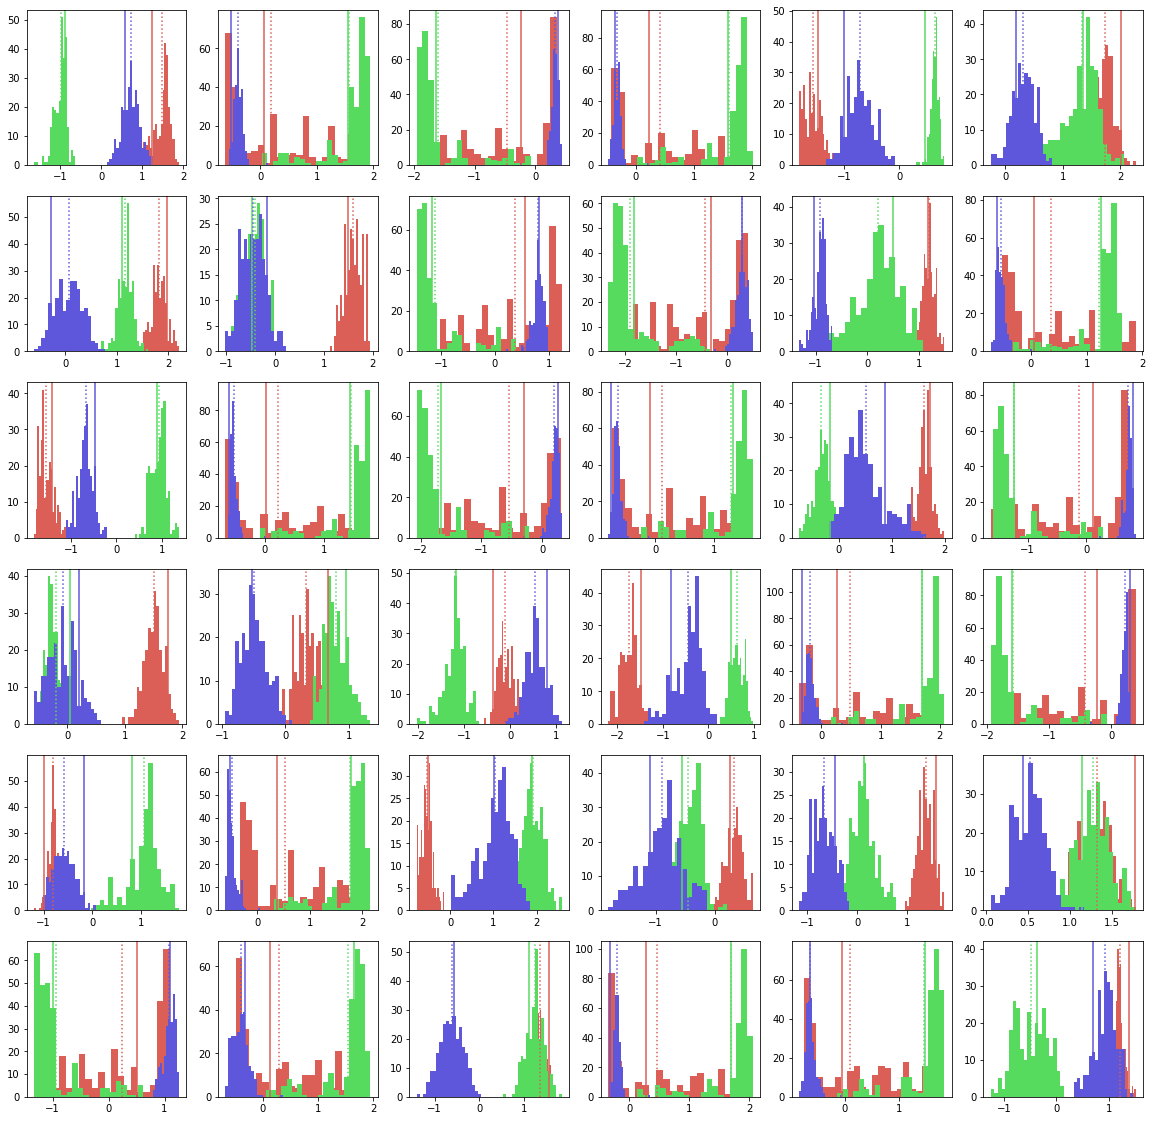

In [31]:
errors = []
rel_error = []
baseline_error = []
num_elem = 0
multi_dataset.set_nsample(args.n_sample)
import seaborn as sns

plt.figure(figsize=(20, 20))
with torch.no_grad():
    for idx, data in enumerate(multi_loader):
        bx, by, bl = data
        bx = bx.to(device)
        
        print(bx.shape)
        actual_feat = feat_model(bx[:, :, -1].view(-1, 1, 64, 64)).view(args.batch_size, args.n_sample, args.feat_size)
        print(actual_feat.shape)
        actual_exp = actual_feat.mean(dim=1)
        print(actual_exp.shape)
        pred_exp = predictor(bx[:, 0, 0:2])
        print(pred_exp.shape)
        
        var = (actual_exp - actual_exp.mean(dim=1, keepdim=True)).abs()
        loss_l2 = (actual_exp - pred_exp).abs().mean()
        print(var.shape)

        errors.append(actual_exp - pred_exp)
        rel_error.append((actual_exp - pred_exp) / (1e-5 + var))

        baseline_error.append(actual_feat[:, :args.n_sample//2, :].mean(dim=1) - actual_feat[:, args.n_sample//2:, :].mean(dim=1))
        num_elem += args.batch_size
        if num_elem > 1000:
            break
        
        
        for i in range(36):
            plt.subplot(6, 6, i+1)
            plt.hist(actual_feat[0, :, i].cpu().numpy(), bins=20, color=palette[idx])
            plt.axvline(pred_exp[0, i], color=palette[idx])
            plt.axvline(actual_exp[0, i], color=palette[idx], linestyle=':')
        plt.savefig(os.path.join(log_dir, 'plot', 'hist-%d.png' % epoch))
#         plt.show()
        
#         plt.figure(figsize=(20, 7))
#         for i in range(3):
#             for j in range(10):
#                 plt.subplot(3, 10, i*10+j+1)
#                 plt.imshow(bx[0, j, i, 0].cpu(), cmap='gray')
#                 plt.axis('off')
#         plt.show()
        if idx == 2:
            break
    errors = torch.cat(errors)
    rel_error = torch.cat(rel_error)
    baseline_error = torch.cat(baseline_error)
